In [1]:
import numpy as np 
import pickle
import math
from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets
import argparse
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional
torch.set_default_dtype(torch.float64)

In [2]:
class Affine_Coupling(nn.Module):
    def __init__(self,mask,hidden_dim):
        super(Affine_Coupling,self).__init__()
        self.input_dim  = len(mask)
        self.hidden_dim = hidden_dim

        self.mask = nn.Parameter(mask,requires_grad=False)

        self.scale_fc1 = nn.Linear(self.input_dim,self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim,self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        self.translation_fc1 = nn.Linear(self.input_dim,self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim,self.input_dim)
    
    def _compute_scale(self,x):
        s = torch.relu(self.scale_fc1(x*self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s))*self.scale
        return s
    def _compute_translation(self,x):
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)
        return t
    
    def forward(self,x):
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s)+t)
        logdet = torch.sum((1-self.mask)*s,-1)
        return y,logdet
    
    def inverse(self,y):
        s = self._compute_scale(y)
        t = self._compute_translation(y)
        x = self.mask*y + (1-self.mask)*((y-t)*torch.exp(-s))
        logdet = torch.sum((1-self.mask)*(-s),-1)
        return x,logdet


In [3]:
class RealNVP_2D(nn.Module):
    def __init__(self,masks,hidden_dim):
        super(RealNVP_2D,self).__init__()
        self.hidden_dim = hidden_dim
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad=False) for m in masks]
        )
        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i],self.hidden_dim) for i in range(len(self.masks))]
        )
    def forward(self,x):
        y = x
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y,logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet
        
        y = 4*torch.tanh(y)
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))),-1)
        logdet_tot = logdet_tot + logdet
        return y, logdet_tot
    
    def inverse(self,y):
        x = y
        logdet_tot = 0
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0*1/(1-(x/4)**2))),-1)
        x = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet

        for i in range(len(self.affine_couplings)-1,-1,-1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet
        return x,logdet_tot

idx_steps: 99,loss: 3.16316
idx_steps: 199,loss: 1.82896
idx_steps: 299,loss: 1.12383
idx_steps: 399,loss: 0.98236
idx_steps: 499,loss: 0.89294
idx_steps: 599,loss: 0.93363
idx_steps: 699,loss: 0.78067
idx_steps: 799,loss: 0.74237
idx_steps: 899,loss: 0.73994
idx_steps: 999,loss: 0.67595
idx_steps: 1099,loss: 0.66881
idx_steps: 1199,loss: 0.77438
idx_steps: 1299,loss: 0.63013
idx_steps: 1399,loss: 0.56858
idx_steps: 1499,loss: 0.53124
idx_steps: 1599,loss: 0.51650
idx_steps: 1699,loss: 0.54351
idx_steps: 1799,loss: 0.62935
idx_steps: 1899,loss: 0.50010
idx_steps: 1999,loss: 0.46425
idx_steps: 2099,loss: 0.45587
idx_steps: 2199,loss: 0.49101
idx_steps: 2299,loss: 0.47721
idx_steps: 2399,loss: 0.41529
idx_steps: 2499,loss: 0.52405
idx_steps: 2599,loss: 0.43612
idx_steps: 2699,loss: 0.47313
idx_steps: 2799,loss: 0.40185
idx_steps: 2899,loss: 0.39993
idx_steps: 2999,loss: 0.44063
idx_steps: 3099,loss: 0.44784
idx_steps: 3199,loss: 0.36172
idx_steps: 3299,loss: 0.40787
idx_steps: 3399,loss:

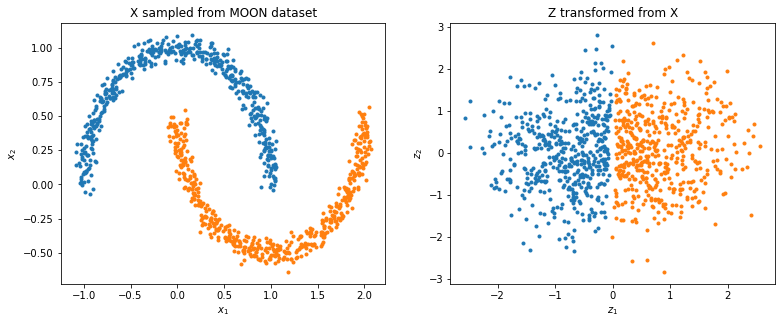

In [7]:
masks = [
    [1.0,0.0],
    [0.0,1.0],
    [1.0,0.0],
    [0.0,1.0],
    [1.0,0.0],
    [0.0,1.0],
    [1.0,0.0],
    [0.0,1.0]
]
hidden_dim = 128
realNVP = RealNVP_2D(masks,hidden_dim)
if torch.cuda.device_count():
    realNVP = realNVP.cuda()
device = next(realNVP.parameters()).device

optimizer = optim.Adam(realNVP.parameters(),lr=0.0001)
num_steps = 5000

for idx_step in range(num_steps):
    X,label = datasets.make_moons(n_samples=512,noise=0.05)
    X = torch.Tensor(X).to(device=device)
    z,logdet = realNVP.inverse(X)
    loss = torch.log(z.new_tensor([2*math.pi]))+torch.mean(torch.sum(0.5*z**2,-1)-logdet)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx_step+1) % 100 == 0:
        print(f"idx_steps: {idx_step:},loss: {loss.item():.5f}")

X,label = datasets.make_moons(n_samples=1000,noise=0.05)
X = torch.Tensor(X).to(device=device)
z,logdet_jacobian = realNVP.inverse(X)
z = z.cpu().detach().numpy()
X = X.cpu().detach().numpy()
fig = plt.figure(2,figsize=(12.8,4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[label==0,0],X[label==0,1],".")
plt.plot(X[label==1,0],X[label==1,1],".")
plt.title("X sampled from MOON dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[label==0,0],z[label==0,1],".")
plt.plot(z[label==1,0],z[label==1,1],".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

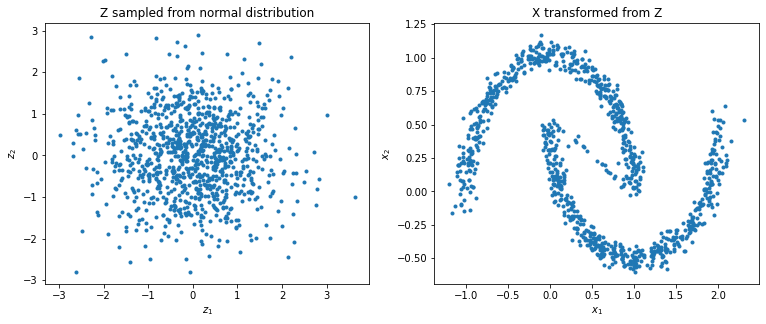

In [8]:
## after learning, we can also test if the model can transform
## the normal distribution into the moon data distribution 
z = torch.normal(0, 1, size = (1000, 2)).to(device = device)
X, _ = realNVP(z)
X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(z[:,0], z[:,1], ".")
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], ".")
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.show()